In [29]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot  as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)

In [30]:
def load_images_from_folder(folder_label_pairs, image_size=None):
    data = []

    for folder, label in folder_label_pairs:
        for filename in os.listdir(folder):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder, filename)
                img = Image.open(img_path).convert('RGB')

                if image_size:
                    img = img.resize(image_size)

                img_array = np.array(img).flatten()
                data.append({
                    'flattened_pixels': img_array,
                    'label': label
                })

    df = pd.DataFrame(data)
    return df

In [31]:
class1_folder = r"E:\POC_Jain_Irrigation\data\A\train_cropped"
class2_folder = r"E:\POC_Jain_Irrigation\data\BC\train_cropped"
class3_folder = r"E:\POC_Jain_Irrigation\data\D\train_cropped"

In [32]:
folders = [
    (class1_folder, 1),
    (class2_folder, 2),
    (class3_folder, 3)
]

In [33]:
widths, heights = [], []

for folder, label in folders:
    print(f"\nChecking folder: {folder} (class {label})")
    for filename in tqdm(os.listdir(folder)):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        path = os.path.join(folder, filename)
        try:
            with Image.open(path) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
        except Exception as e:
            print(f"Skipped {filename}: {e}")

widths, heights = np.array(widths), np.array(heights)

print("\n===== IMAGE SIZE SUMMARY =====")
print(f"Total images: {len(widths)}")
print(f"Width  → min: {widths.min()}, max: {widths.max()}, mean: {widths.mean():.1f}")
print(f"Height → min: {heights.min()}, max: {heights.max()}, mean: {heights.mean():.1f}")


Checking folder: E:\POC_Jain_Irrigation\data\A\train_cropped (class 1)


100%|███████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 10405.50it/s]



Checking folder: E:\POC_Jain_Irrigation\data\BC\train_cropped (class 2)


100%|███████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 16545.58it/s]



Checking folder: E:\POC_Jain_Irrigation\data\D\train_cropped (class 3)


100%|███████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 12395.23it/s]


===== IMAGE SIZE SUMMARY =====
Total images: 256
Width  → min: 644, max: 3000, mean: 883.6
Height → min: 698, max: 3373, mean: 903.9


In [34]:
def load_images_with_padding(folder_label_pairs, image_size=(512,512), pad_color=(255,255,255)):
    """
    Loads all images from the given folders, resizes while preserving aspect ratio,
    and pads them with a neutral color to make them uniform-sized.
    
    Parameters
    ----------
    folder_label_pairs : list of (folder_path, label)
        Folders and corresponding labels.
    image_size : tuple (width, height)
        Target final image size after padding.
    pad_color : tuple (R,G,B)
        Color used for padding (default white).
    
    Returns
    -------
    pd.DataFrame with 'flattened_pixels' and 'label' columns.
    """
    data = []

    for folder, label in folder_label_pairs:
        image_files = [f for f in os.listdir(folder)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for filename in tqdm(image_files, desc=f"Processing {os.path.basename(folder)}"):
            path = os.path.join(folder, filename)
            try:
                img = Image.open(path).convert("RGB")

                # Preserve aspect ratio
                img.thumbnail(image_size, Image.Resampling.LANCZOS)

                # Create white background
                background = Image.new("RGB", image_size, pad_color)
                offset = (
                    (image_size[0] - img.width) // 2,
                    (image_size[1] - img.height) // 2
                )
                background.paste(img, offset)

                img_array = np.array(background) / 255.0   # normalize
                flat = img_array.flatten()

                data.append({
                    'flattened_pixels': flat,
                    'label': label
                })
            except Exception as e:
                print(f"⚠️ Skipped {filename}: {e}")

    df = pd.DataFrame(data)
    return df

In [35]:
df = load_images_with_padding(folders)
print(df.head())
print(df.shape)

Processing train_cropped: 100%|████████████████████████████████████████████████████████| 92/92 [00:01<00:00, 61.08it/s]

                                    flattened_pixels  label
0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...      1
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...      1
2  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...      1
3  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...      1
4  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...      1
(256, 2)


In [36]:
arr = df.iloc[1, 0]
print("Min:", arr.min())
print("Max:", arr.max())

Min: 0.0
Max: 1.0


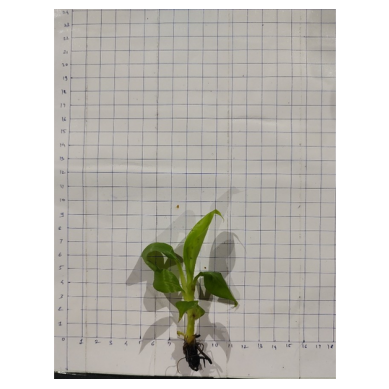

In [37]:
img = arr.reshape(512, 512, 3)  # use your image_size used in preprocessing

import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis('off')
plt.show()

In [38]:
X = np.stack(df['flattened_pixels'].values)
y = df['label'].values

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (256, 786432)
y shape: (256,)


In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [40]:
softmax_1 = LogisticRegression(
    max_iter=2000,
    solver='lbfgs',
    multi_class='multinomial',
    verbose=1,
    n_jobs=-1
)
softmax_1.fit(X_train, y_train)

E:\Jain Irrigation\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'multinomial'


In [41]:
import joblib

joblib.dump(softmax_1, "softmax_1.pkl")

['softmax_1.pkl']

Train Accuracy: 1.0
Test Accuracy: 0.8311688311688312

--- TRAIN REPORT ---
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        57
           2       1.00      1.00      1.00        58
           3       1.00      1.00      1.00        64

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179


--- TEST REPORT ---
              precision    recall  f1-score   support

           1       0.78      0.84      0.81        25
           2       0.78      0.75      0.77        24
           3       0.93      0.89      0.91        28

    accuracy                           0.83        77
   macro avg       0.83      0.83      0.83        77
weighted avg       0.83      0.83      0.83        77



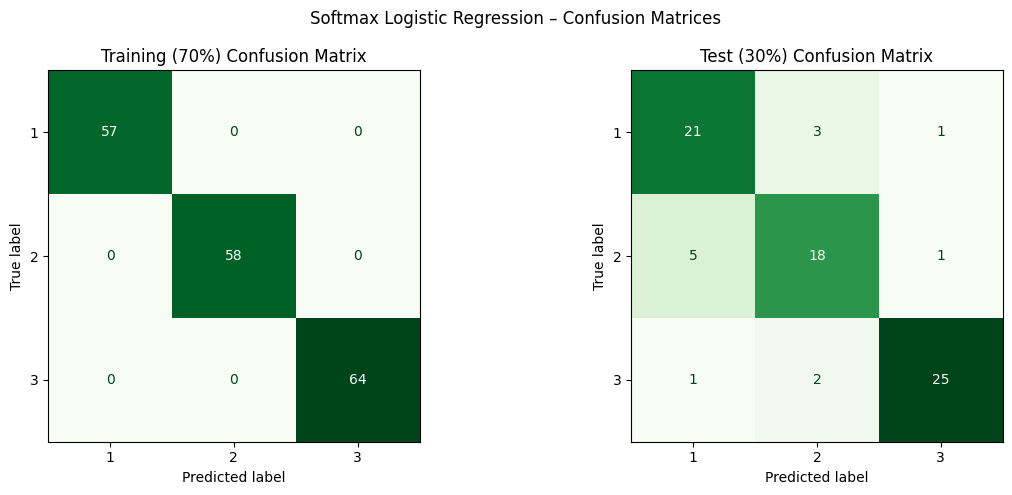


=== Predictions with Probabilities (Logistic Regression) ===
Sample 1    | True: 1          | Pred: 1         
  → Probabilities: 1: 0.8231 | 2: 0.1769 | 3: 0.0000
----------------------------------------------------------------------------------------------------
Sample 2    | True: 3          | Pred: 2         
  → Probabilities: 1: 0.0000 | 2: 0.7951 | 3: 0.2049
----------------------------------------------------------------------------------------------------
Sample 3    | True: 2          | Pred: 2         
  → Probabilities: 1: 0.1643 | 2: 0.8353 | 3: 0.0004
----------------------------------------------------------------------------------------------------
Sample 4    | True: 1          | Pred: 1         
  → Probabilities: 1: 1.0000 | 2: 0.0000 | 3: 0.0000
----------------------------------------------------------------------------------------------------
Sample 5    | True: 1          | Pred: 2         
  → Probabilities: 1: 0.1697 | 2: 0.7868 | 3: 0.0436
-------------------

In [42]:
y_pred_train = softmax_1.predict(X_train)
y_pred_test = softmax_1.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))

print("\n--- TRAIN REPORT ---")
print(classification_report(y_train, y_pred_train, zero_division=0))

print("\n--- TEST REPORT ---")
print(classification_report(y_test, y_pred_test, zero_division=0))

# ============================================================
# 📊 2. Confusion Matrices
# ============================================================
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=softmax_1.classes_)
disp_train.plot(ax=axes[0], cmap='Greens', colorbar=False)
axes[0].set_title("Training (70%) Confusion Matrix")

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=softmax_1.classes_)
disp_test.plot(ax=axes[1], cmap='Greens', colorbar=False)
axes[1].set_title("Test (30%) Confusion Matrix")

plt.suptitle("Softmax Logistic Regression – Confusion Matrices")
plt.tight_layout()
plt.show()

# ============================================================
# 🔍 3. Display Softmax Probabilities per Sample (All Classes)
# ============================================================
print("\n=== Predictions with Probabilities (Logistic Regression) ===")

probs = softmax_1.predict_proba(X_test)
class_names = list(softmax_1.classes_)

# Loop through samples
for i in range(len(X_test)):
    pred_idx = np.argmax(probs[i])
    pred_name = class_names[pred_idx]
    true_name = y_test[i]
    
    # Build probability string for all classes
    prob_str = " | ".join([f"{cls}: {probs[i][j]:.4f}" for j, cls in enumerate(class_names)])
    
    print(f"Sample {i+1:<4} | True: {true_name:<10} | Pred: {pred_name:<10}")
    print(f"  → Probabilities: {prob_str}")
    print("-" * 100)

# ============================================================
# 💾 4. Save Predictions (with All Class Probabilities)
# ============================================================
df = pd.DataFrame({
    "True_Class": y_test,
    "Predicted_Class": y_pred_test,
    "Top_Probability": probs.max(axis=1)
})

# Add all class probabilities as separate columns
for j, cls in enumerate(class_names):
    df[f"Prob_{cls}"] = probs[:, j]

df.to_csv("logreg_predictions_with_probs.csv", index=False)
print("\n✅ Saved detailed predictions to 'logreg_predictions_with_probs.csv'")

In [27]:
print("Classes in model:", softmax_1.classes_)

Classes in model: [1 2 3 4]


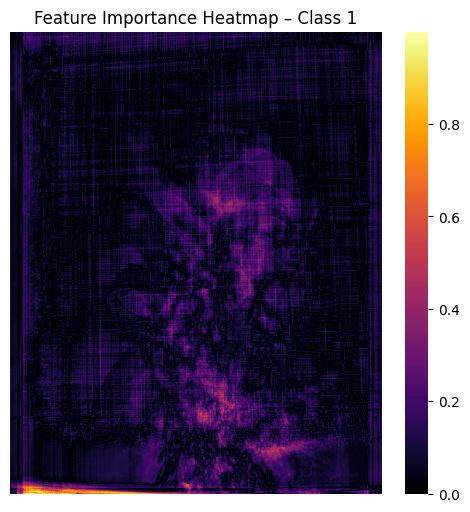

In [28]:
H, W, C = 512, 512, 3

# Choose class index (e.g., 0 for label 1, 1 for label 2, etc.)
class_idx = 0   # change to visualize for different classes

# Extract coefficients for that class
coef_class = softmax_1.coef_[class_idx]

# Reshape back into image format
coef_img = coef_class.reshape(H, W, C)

# Convert to grayscale importance map (mean of absolute RGB weights)
importance = np.mean(np.abs(coef_img), axis=2)

# Normalize to 0–1 for visualization
importance_norm = (importance - importance.min()) / (np.ptp(importance) + 1e-8)

plt.figure(figsize=(6,6))
sns.heatmap(importance_norm, cmap='inferno', cbar=True)
plt.title(f"Feature Importance Heatmap – Class {softmax_1.classes_[class_idx]}")
plt.axis('off')
plt.show()

In [38]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [39]:
lin_reg_coef = pd.DataFrame(
    lin_reg.coef_.reshape(1, -1),
    columns=[f"Feature_{i}" for i in range(X_train.shape[1])]
)

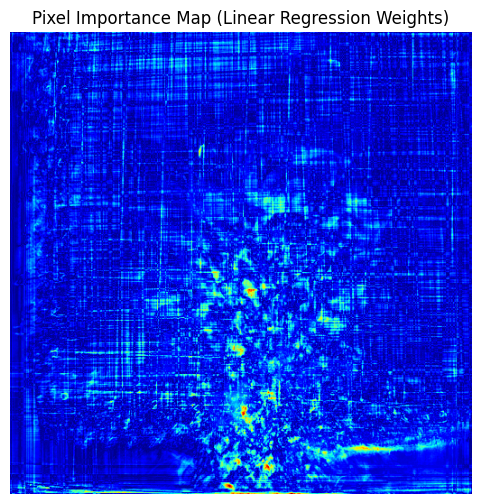

In [40]:
# Original image shape
H, W, C = 512, 512, 3

# Reshape coefficients to image shape
weight_map_rgb = lin_reg.coef_.reshape(H, W, C)

# Convert RGB weights → single importance value per pixel
weight_map = np.linalg.norm(weight_map_rgb, axis=2)

# Normalize for visualization
weight_map_norm = (weight_map - weight_map.min()) / (weight_map.max() - weight_map.min())

# Plot importance map
plt.figure(figsize=(6, 6))
plt.imshow(weight_map_norm, cmap='jet')
plt.title("Pixel Importance Map (Linear Regression Weights)")
plt.axis('off')
plt.show()